In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import tree, ensemble, neighbors, naive_bayes, decomposition, linear_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam


Using TensorFlow backend.


#### Read In Data

In [2]:
#cityData = pd.read_csv('foursquare-nyc-and-tokyo-check-ins\\dataset_TSMC2014_NYC.csv')
cityData = pd.read_csv('foursquare-nyc-and-tokyo-check-ins\\dataset_TSMC2014_TKY.csv')

print("Number of Check-In Records: ", cityData.shape[0])
print("Number of Unique Checkin Venues: ", len(np.unique(cityData.venueId)))
print("Number of Unique Venue Categories: ", len(np.unique(cityData.venueCategory)))
print("Number of Unique User IDs: ", len(np.unique(cityData.userId)))

Number of Check-In Records:  573703
Number of Unique Checkin Venues:  61858
Number of Unique Venue Categories:  247
Number of Unique User IDs:  2293


In [3]:
cityData.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012


### Temporal Features

#### Convert UTC Time to Local Time

In [4]:
cityData['localTime'] = pd.to_datetime(cityData.utcTimestamp) + pd.to_timedelta(cityData.timezoneOffset, unit = 'm')

#### Add Day and Hour Info as Features

In [5]:
# Day of week, 0 = Monday, 6 = Sunday
cityData['localDayofWeek'] = cityData.localTime.dt.dayofweek
# Use only Hour component
cityData['localHour'] = cityData.localTime.dt.hour

In [6]:
cityData

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,localTime,localDayofWeek,localHour
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012,2012-04-04 03:17:18,2,3
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012,2012-04-04 03:22:04,2,3
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012,2012-04-04 04:12:07,2,4
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012,2012-04-04 04:12:13,2,4
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012,2012-04-04 04:18:23,2,4
5,1541,4b83b207f964a5202c0d31e3,4bf58dd8d48988d1f8941735,Furniture / Home Store,35.705074,139.619502,540,Tue Apr 03 19:20:09 +0000 2012,2012-04-04 04:20:09,2,4
6,1541,4ea281c302d529c116a57755,4d954b0ea243a5684a65b473,Convenience Store,35.706277,139.617782,540,Tue Apr 03 19:21:00 +0000 2012,2012-04-04 04:21:00,2,4
7,114,4b3eae5cf964a520b4a025e3,4bf58dd8d48988d129951735,Train Station,35.700253,139.480255,540,Tue Apr 03 19:35:36 +0000 2012,2012-04-04 04:35:36,2,4
8,1635,4cca7bd67965b60c80f0858a,4bf58dd8d48988d162941735,Other Great Outdoors,35.755759,139.733573,540,Tue Apr 03 19:51:50 +0000 2012,2012-04-04 04:51:50,2,4
9,2033,4b5c7671f964a520083129e3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.693121,139.699448,540,Tue Apr 03 19:51:59 +0000 2012,2012-04-04 04:51:59,2,4


#### Convert Coordinate System

In [7]:
def convertCoord(lat, long):
    
    # Earth's radius = 6371 km
    R = 6371
    
    x = R * math.cos(math.radians(lat)) * math.cos(math.radians(long))
    y = R * math.cos(math.radians(lat)) * math.sin(math.radians(long))
    z = R * math.sin(math.radians(lat))
    
    return [x, y, z]

In [8]:
LocData = cityData.loc[:, ['userId', 'latitude', 'longitude']].as_matrix()

convCoords = []

for i in range(LocData.shape[0]):    
    convCoords.append(convertCoord(LocData[i, 1], LocData[i, 2]))

convCoords = np.array(convCoords)

cityData['x'] = convCoords[:, 0]
cityData['y'] = convCoords[:, 1]
cityData['z'] = convCoords[:, 2]

cityMeanX, cityMeanY, cityMeanZ = cityData[['x', 'y', 'z']].mean()


#### Write Last Location and Mean Historical Location

In [9]:
LocData = cityData.loc[:, ['userId', 'latitude', 'longitude', 'x', 'y', 'z', 'localTime', 'venueCategory']].as_matrix()

usrLastLat = []
usrLastLong = []
usrLastX = []
usrLastY = []
usrLastZ = []
usrLastTime = []
usrLastCat = []
usrMeanX = []
usrMeanY = []
usrMeanZ = []

for i in range(LocData.shape[0]):
    currUser = LocData[i, 0]
    histLoc = LocData[:i, :]
    histLoc = histLoc[histLoc[:, 0] == currUser, :]
    
    if histLoc.shape[0] == 0:
        usrLastLat.append(float('nan'))
        usrLastLong.append(float('nan'))
        usrLastX.append(float('nan'))
        usrLastY.append(float('nan'))
        usrLastZ.append(float('nan'))
        usrLastTime.append(pd.to_datetime('NaT'))
        usrLastCat.append('')
        usrMeanX.append(float('nan'))
        usrMeanY.append(float('nan'))
        usrMeanZ.append(float('nan'))
    else:
        usrLastLat.append(histLoc[-1, 1])
        usrLastLong.append(histLoc[-1, 2])
        usrLastX.append(histLoc[-1, 3])
        usrLastY.append(histLoc[-1, 4])
        usrLastZ.append(histLoc[-1, 5])
        usrLastTime.append(histLoc[-1, 6])
        usrLastCat.append(histLoc[-1, 7])
        usrMeanX.append(np.mean(histLoc[:, 3]))
        usrMeanY.append(np.mean(histLoc[:, 4]))
        usrMeanZ.append(np.mean(histLoc[:, 5]))
    
    if i % 100000 == 0:
        print("Processing Record ", i)

cityData['usrLastLat'] = usrLastLat
cityData['usrLastLong'] = usrLastLong
cityData['usrLastX'] = usrLastX
cityData['usrLastY'] = usrLastY
cityData['usrLastZ'] = usrLastZ
cityData['usrLastTime'] = usrLastTime
cityData['usrLastCat'] = usrLastCat
cityData['usrMeanX'] = usrMeanX
cityData['usrMeanY'] = usrMeanY
cityData['usrMeanZ'] = usrMeanZ

cityData['usrLastDist'] = np.linalg.norm(cityData.loc[:, ['x', 'y', 'z']].as_matrix() - 
                                         cityData.loc[:, ['usrLastX', 'usrLastY', 'usrLastZ']].as_matrix(), 
                                         axis = 1)
cityData['usrMeanDist'] = np.linalg.norm(cityData.loc[:, ['x', 'y', 'z']].as_matrix() - 
                                         cityData.loc[:, ['usrMeanX', 'usrMeanY', 'usrMeanZ']].as_matrix(), 
                                         axis = 1)
cityData['usrLastTimeDiff'] = pd.to_timedelta(cityData.loc[:, 'localTime'].as_matrix() - 
                                              cityData.loc[:, 'usrLastTime'].as_matrix(), 
                                              unit = 's').seconds

Processing Record  0
Processing Record  100000
Processing Record  200000
Processing Record  300000
Processing Record  400000
Processing Record  500000


In [10]:
cityData.to_csv('foursquare-nyc-and-tokyo-check-ins\\dataset_TSMC2014_TKY_processed.csv', index = False, encoding='utf-8')

#cityData = pd.read_csv('foursquare-nyc-and-tokyo-check-ins\\dataset_TSMC2014_TKY_processed.csv')
#cityData.localTime = pd.to_datetime(cityData.localTime)

#### Map of Venue to Category

In [11]:
# Mapping between venue and category
venueCatMap = cityData.groupby(['venueId', 'venueCategory']).count()
venueCatMap.reset_index(inplace = True)
venueCatMap = venueCatMap.loc[:, ['venueId', 'venueCategory']]

# Remove duplicated venue ID: with more than 1 category
dropIdx = venueCatMap.duplicated('venueId')
venueCatMap = venueCatMap.loc[~dropIdx, :]
venueCatMap.set_index('venueId', inplace = True)

# 301 duplicated categories
print("Number of Duplicated Venue-Category Pairs Dropped: ", np.sum(dropIdx))

Number of Duplicated Venue-Category Pairs Dropped:  520


### Data Exploration

Most users consistently use it over long periods. Hence they aren't tourists and should have consistent visit patterns.

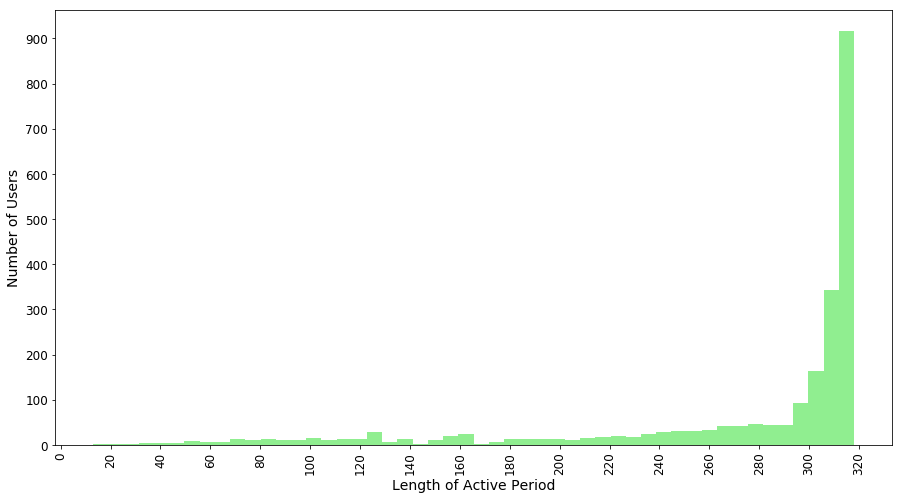

In [12]:
# x = localTime
def activePeriods(x):    
    numUsages = len(x)    
    if numUsages == 1:
        return pd.to_timedelta(0)
    else:
        return max(x) - min(x)

usrActPeriods = cityData.groupby(['userId'])['localTime'].agg(activePeriods)

# Most users consistently use it over long periods
plt.figure(figsize = (15, 8))
plt.hist(usrActPeriods.dt.days, bins = 50, color = "lightgreen")
plt.xticks(np.arange(0, 321, 20), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 901, 100), fontsize = 12)
plt.xlabel("Length of Active Period", fontsize = 14)
plt.ylabel("Number of Users", fontsize = 14)
plt.show()
plt.close()

The users have more than 100 usage counts in the entire period.

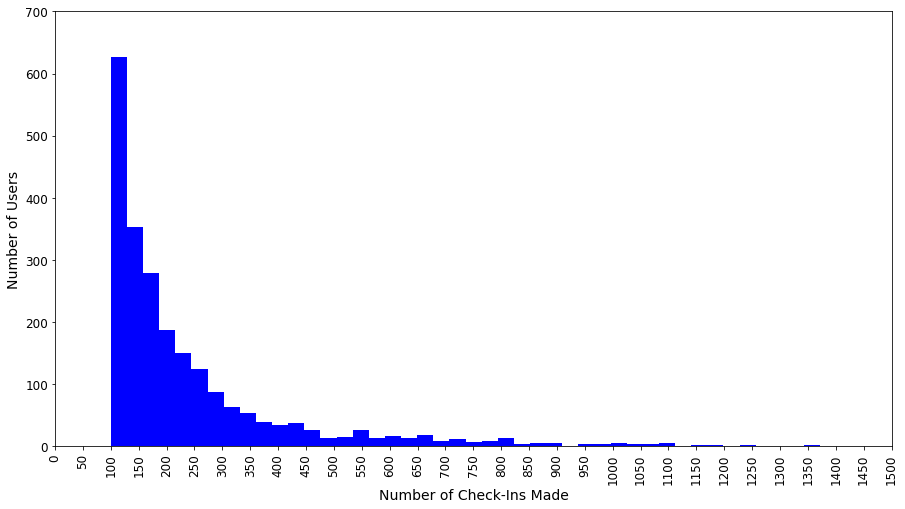

In [13]:
# Usage count of each user
plt.figure(figsize = (15, 8))
plt.hist(list(cityData.groupby('userId')['venueId'].count()), bins = 100, color = 'blue')
plt.xticks(np.arange(0, 3001, 50), rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.axis([0, 1501, 0, 700])
plt.xlabel("Number of Check-Ins Made", fontsize = 14)
plt.ylabel("Number of Users", fontsize = 14)
plt.show()
plt.close()


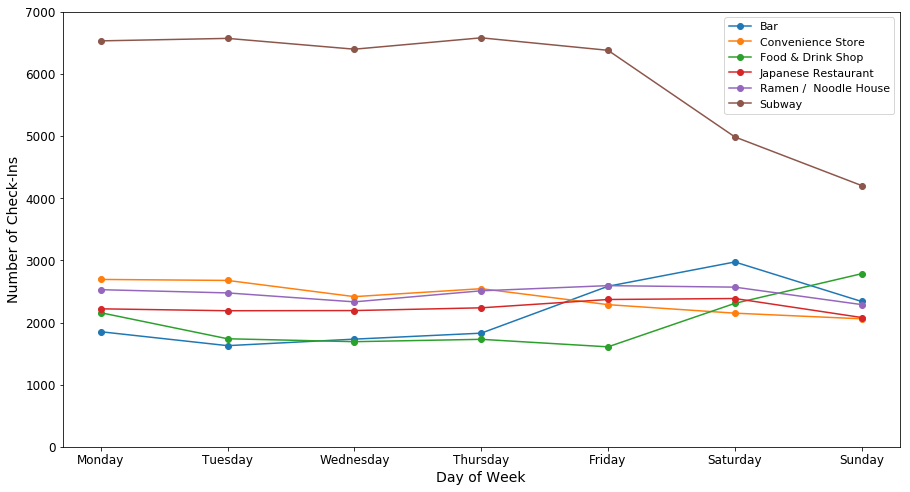

In [14]:
topSixCats = cityData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False)[1:7] # Skip Train Station Category
topSixCats_ByDay = cityData.loc[cityData.venueCategory.isin(topSixCats.index.tolist()), :] \
                        .groupby(['venueCategory', 'localDayofWeek'])['localTime'].count()

plt.figure(figsize = (15, 8))

for cat in topSixCats_ByDay.index.levels[0].tolist():
    plt.plot(topSixCats_ByDay[cat].index.tolist(), topSixCats_ByDay[cat].values, marker = 'o', label = cat)

plt.xticks(np.arange(0, 7, 1), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), fontsize = 12)
plt.yticks(np.arange(0, 7001, 1000), fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 11)
plt.ylabel('Number of Check-Ins', fontsize = 14)
plt.xlabel('Day of Week', fontsize = 14)
plt.show()
plt.close()


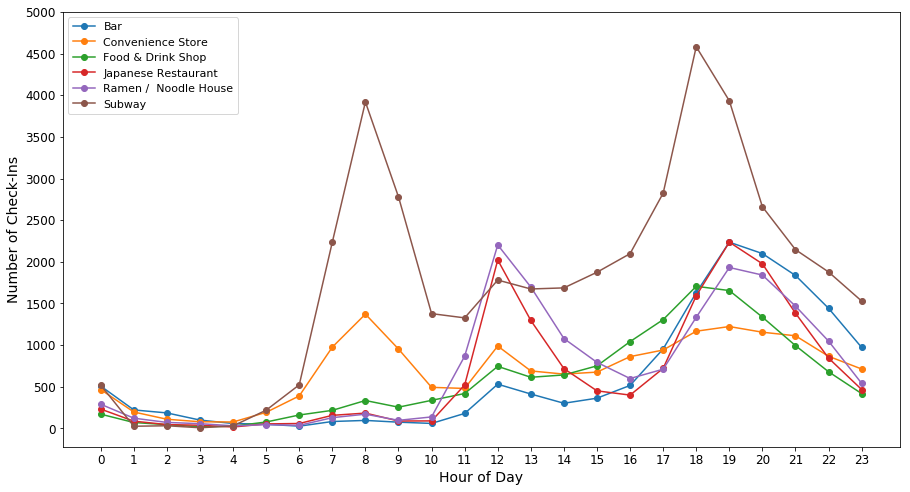

In [15]:
topSixCats_ByHour = cityData.loc[cityData.venueCategory.isin(topSixCats.index.tolist()), :] \
                        .groupby(['venueCategory', 'localHour'])['localTime'].count()

plt.figure(figsize = (15, 8))

for cat in topSixCats_ByHour.index.levels[0].tolist():
    plt.plot(topSixCats_ByHour[cat].index.tolist(), topSixCats_ByHour[cat].values, marker = 'o', label = cat)

plt.xticks(np.arange(0, 24, 1), fontsize = 12)
plt.yticks(np.arange(0, 5001, 500), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Number of Check-Ins', fontsize = 14)
plt.xlabel('Hour of Day', fontsize = 14)
plt.show()
plt.close()


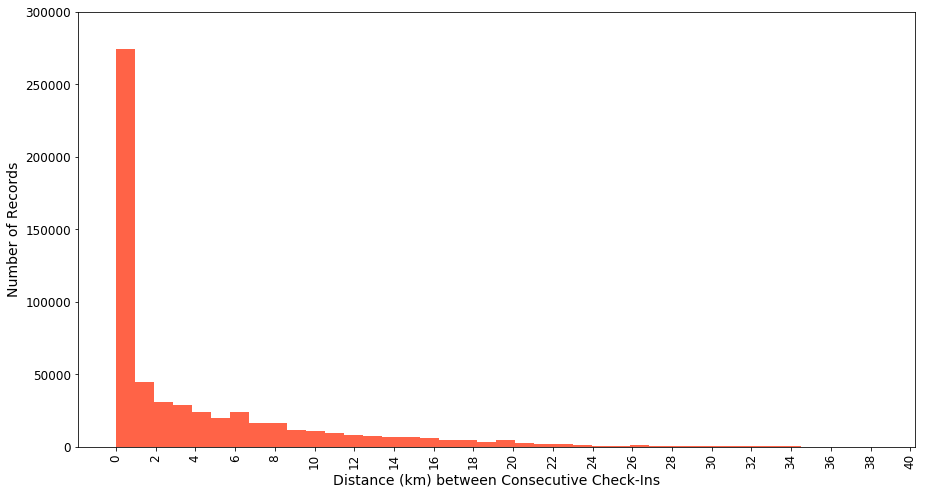

In [16]:
plt.figure(figsize = (15, 8))
plt.hist(cityData.usrLastDist[~pd.isnull(cityData.usrLastDist)], bins = 40, color = 'tomato')
plt.xticks(np.arange(0, 41, 2), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 300001, 50000), rotation = 0, fontsize = 12)
plt.xlabel("Distance (km) between Consecutive Check-Ins", fontsize = 14)
plt.ylabel("Number of Records", fontsize = 14)
plt.show()
plt.close()

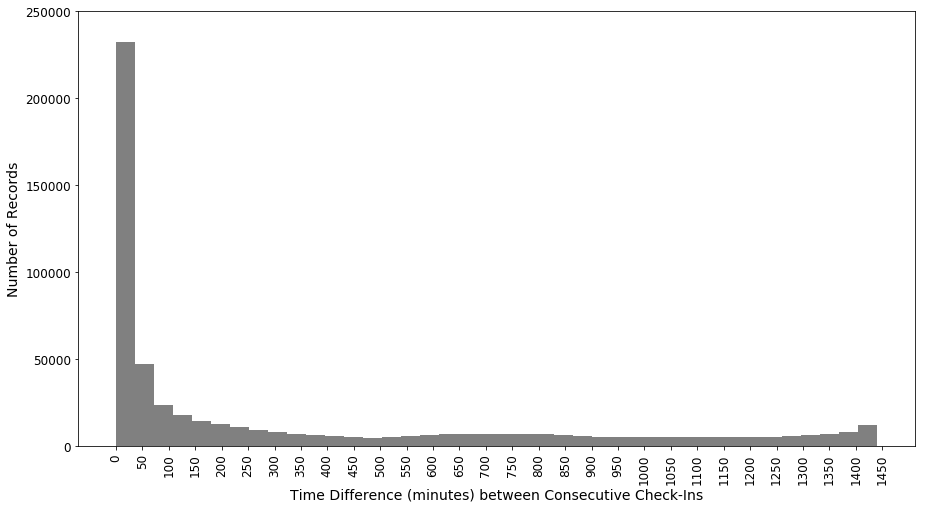

In [17]:
plt.figure(figsize = (15, 8))
plt.hist(cityData.usrLastTimeDiff[~pd.isnull(cityData.usrLastTimeDiff)] / 60, bins = 40, color = 'gray')
plt.xticks(np.arange(0, 1451, 50), rotation = 90, fontsize = 12)
plt.yticks(np.arange(0, 250001, 50000), rotation = 0, fontsize = 12)
plt.xlabel("Time Difference (minutes) between Consecutive Check-Ins", fontsize = 14)
plt.ylabel("Number of Records", fontsize = 14)
plt.show()
plt.close()

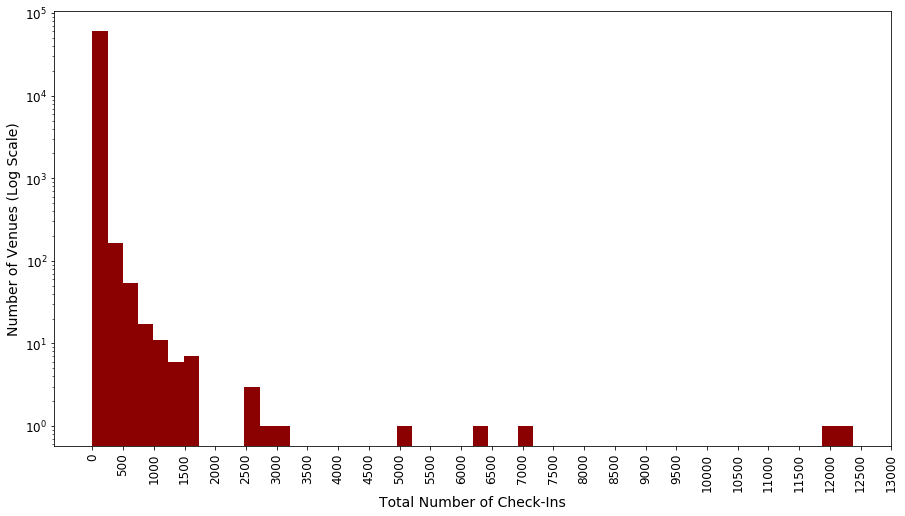

In [18]:
plt.figure(figsize = (15, 8))
plt.hist(list(cityData.groupby(['venueId'])['userId'].count()), color = 'darkred', bins = 50)
plt.gca().set_yscale("log")
plt.xticks(np.arange(0, 13001, 500), rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Total Number of Check-Ins", fontsize = 14)
plt.ylabel("Number of Venues (Log Scale)", fontsize = 14)
plt.show()
plt.close()

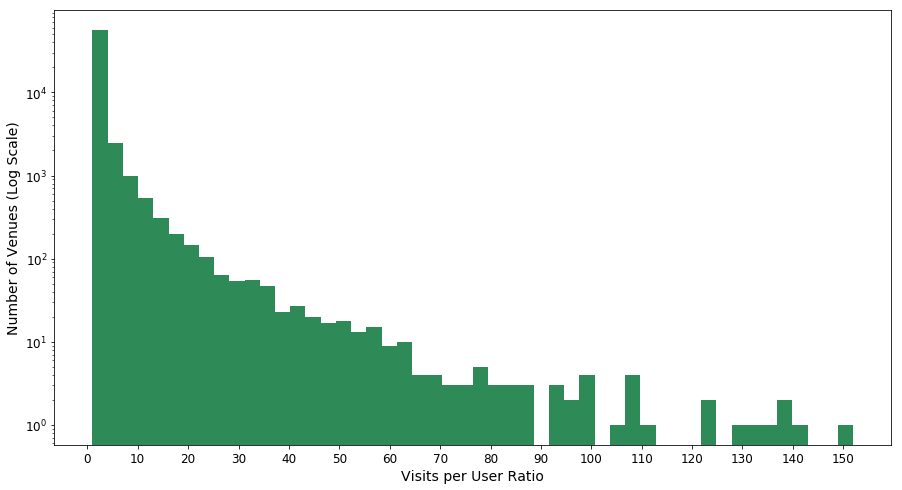

In [19]:
venueCheckIn = cityData.groupby(['venueId', 'userId'])['localTime', 'venueCategory'].count()
venueCheckIn.reset_index(inplace = True)
venueCheckIn = venueCheckIn.loc[:, ['venueId', 'userId', 'localTime']]

# userId = Num of Unique Users, localTime = number of Check-Ins
venueCheckIn = venueCheckIn.groupby(['venueId']).agg({'userId': 'count', 'localTime': 'sum'})

# For each venue, number of check-ins / number of unique customers
plt.figure(figsize = (15, 8))
plt.hist(venueCheckIn.localTime / venueCheckIn.userId, bins = 50, color = 'seagreen')
plt.yscale('log', nonposy='clip')
plt.xticks(np.arange(0, 160, 10), rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Visits per User Ratio", fontsize = 14)
plt.ylabel("Number of Venues (Log Scale)", fontsize = 14)
plt.show()
plt.close()

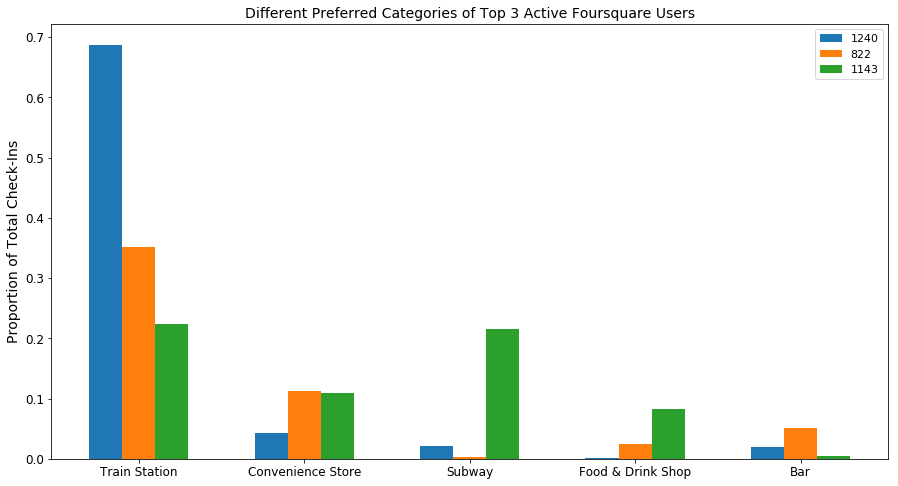

In [20]:
topThreeUsr = cityData.groupby(['userId'])['venueId'].count().sort_values(ascending = False)[:3] # Skip Train Station Category
topEightCat = cityData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False)[:8]
topThreeUsr_ByCat = cityData.loc[cityData.userId.isin(topThreeUsr.index.tolist()) & \
                                 cityData.venueCategory.isin(topEightCat.index.tolist()), :] \
                                    .groupby(['userId', 'venueCategory'])['localTime'].count()

topThreeUsr_CatNorm = topThreeUsr_ByCat / topThreeUsr

N_Display = 5

ind = np.arange(N_Display)  # the x locations for the groups
width = 0.2      # the width of the bars

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)

xSequence = topThreeUsr_CatNorm.groupby(level = 1).sum().sort_values(ascending = False).index.tolist()
usrSequence = topThreeUsr_CatNorm.iloc[topThreeUsr_CatNorm.index.get_level_values('venueCategory') == 'Train Station'] \
                .sort_values(ascending = False).index.get_level_values(0).tolist()

i = 0
for usr in usrSequence:
    ax.bar(ind + i*width, topThreeUsr_CatNorm[int(usr)][xSequence].values[:N_Display], width, label = str(usr))
    i += 1

ax.set_ylabel('Proportion of Total Check-Ins', fontsize = 14)
ax.set_title('Different Preferred Categories of Top 3 Active Foursquare Users', fontsize = 14)
ax.set_xticks(ind + width)
ax.set_xticklabels(xSequence[:N_Display], fontsize = 12)
ax.set_yticklabels(np.arange(0, 0.71, 0.1), fontsize = 12)

plt.legend(loc = 'upper right', fontsize = 11)

plt.show()
plt.close()

In [21]:
pd.DataFrame(cityData.groupby(['venueId']).agg({'localTime': 'count', 'venueCategory': 'first'}).sort_values(by = 'localTime', 
                                                                                                             ascending = False)).head(150)

,venueCategory,localTime
venueId,,
4b19f917f964a520abe623e3,Train Station,12372
4b0587a6f964a5203d9e22e3,Train Station,11891
4b243a7df964a520356424e3,Train Station,6969
4b093eeff964a520e51423e3,Train Station,6408
4b0587a6f964a5203e9e22e3,Train Station,5006
4b0e60adf964a520305723e3,Train Station,3040
4b55670ff964a52071e327e3,Electronics Store,2840
4b19f837f964a520a2e623e3,Train Station,2663
4b274cf5f964a520bf8524e3,Train Station,2634


#### Discard Venues with no more than 100 visits

In [22]:
# Discard venue with less than 100 visits
venueVisit = cityData.groupby('venueId')['localTime'].count()
discardVenue = list(venueVisit[venueVisit <= 100].index)

print("Number of records with venue visited not more than 100 times:", np.sum(venueVisit[venueVisit <= 100]))
print("Number of venues visited not more than 100 times:", len(discardVenue))

cityData_Reduced = cityData.loc[~cityData['venueId'].isin(discardVenue), :]

print("Number of records in reduced dataset: ", cityData_Reduced.shape[0])
print("Number of unique venues in reduced dataset: ", len(set(cityData_Reduced.venueId)))
print("Number of unique venue categories in reduced dataset: ", len(set(cityData_Reduced.venueCategory)))

Number of records with venue visited not more than 100 times: 309032
Number of venues visited not more than 100 times: 61100
Number of records in reduced dataset:  264671
Number of unique venues in reduced dataset:  758
Number of unique venue categories in reduced dataset:  63


In [23]:
# Venue average coordinates - True Geographical Locations of Venues
venueCoord = cityData.groupby(['venueId'])['x', 'y', 'z'].mean()
venueCoord_reduced = venueCoord.loc[venueCoord.index.isin(set(cityData_Reduced.venueId)), :]

venueCoord_reduced

,x,y,z
venueId,,,
4b0587a1f964a5207f9d22e3,-3950.795425,3339.067051,3719.070816
4b0587a1f964a520989d22e3,-3945.488894,3343.867787,3720.390653
4b0587a1f964a5209b9d22e3,-3949.507611,3340.657183,3719.010651
4b0587a6f964a5203d9e22e3,-3946.352722,3346.717430,3716.910497
4b0587a6f964a5203e9e22e3,-3950.660381,3342.577797,3716.059368
4b0587a6f964a520529e22e3,-3949.538866,3345.982333,3714.187121
4b0587a9f964a520d09e22e3,-3953.529893,3341.819807,3713.688566
4b0587b4f964a520a6a022e3,-3945.063923,3344.133450,3720.602521
4b0587bbf964a5209aa122e3,-3942.685635,3349.576549,3718.226448


In [24]:
discardVenueDF = cityData.loc[cityData.venueId.isin(discardVenue), :]
discardVenueDF = discardVenueDF.groupby('venueId').first()
discardVenueDF.groupby('venueCategory')['localTime'].count().sort_values(ascending = False)

venueCategory
Japanese Restaurant                5511
Bar                                4002
Ramen /  Noodle House              3599
Convenience Store                  3138
Café                               2182
Food & Drink Shop                  2122
Chinese Restaurant                 1603
Italian Restaurant                 1162
Bus Station                        1155
Medical Center                     1112
Office                             1112
Coffee Shop                        1105
Road                               1084
Fast Food Restaurant               1045
Clothing Store                     1003
Restaurant                          992
Train Station                       935
Park                                933
Miscellaneous Shop                  845
Bridge                              800
BBQ Joint                           734
Indian Restaurant                   701
Drugstore / Pharmacy                693
Government Building                 655
Bookstore                 

## Data Splitting

Records Distribution

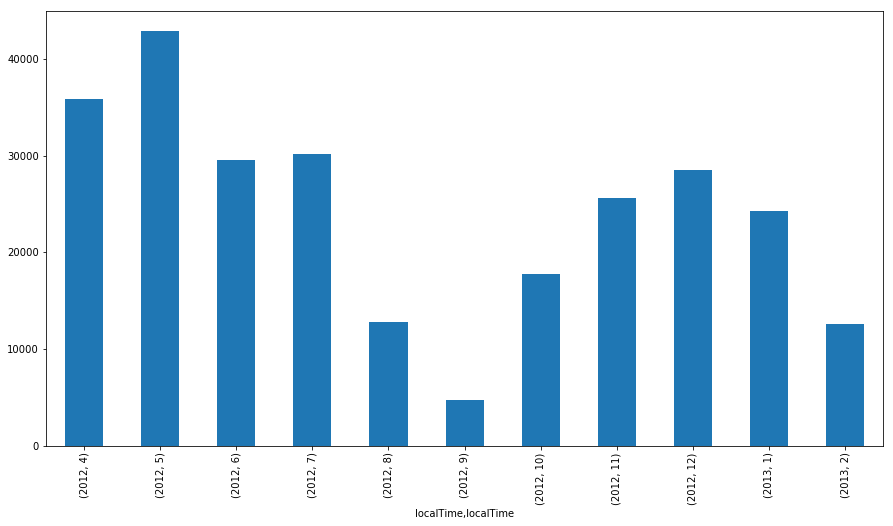

In [25]:
# Histogram by month
plt.figure(figsize = (15, 8))
cityData_Reduced.groupby([cityData_Reduced.localTime.dt.year, cityData_Reduced.localTime.dt.month])['localTime'] \
    .count().plot(kind = "bar")
plt.show()
plt.close()

In [26]:
cutOffIdx = round(cityData_Reduced.shape[0] * 0.7) # Allocate 30% Test Data
trainData = cityData_Reduced.iloc[:cutOffIdx, :]
testData = cityData_Reduced.iloc[cutOffIdx:, :]

In [27]:
print("Earliest timestamp in Training Set: ", min(trainData.localTime))
print("Latest timestamp in Training Set: ", max(trainData.localTime))
print("Number of check-in records in Training Set: ", trainData.shape[0])
print("Number of Unique Users in Training Set: ", len(np.unique(trainData.userId)))
print("Number of Unique Checkin Venues in Training Set: ", len(np.unique(trainData.venueId)))
print("Number of Unique Venue Categories in Training Set: ", len(np.unique(trainData.venueCategory)))
print("Earliest timestamp in Test Set: ", min(testData.localTime))
print("Latest timestamp in Test Set: ", max(testData.localTime))
print("Number of check-in records in Test Set: ", testData.shape[0])
print("Number of Unique Users in Test Set: ", len(np.unique(testData.userId)))
print("Number of Unique Checkin Venues in Test Set: ", len(np.unique(testData.venueId)))
print("Number of Unique Venue Categories in Test Set: ", len(np.unique(testData.venueCategory)))
print("Number of Unique Users in Test Set: ", len(np.unique(testData.userId)))

Earliest timestamp in Training Set:  2012-04-04 04:35:36
Latest timestamp in Training Set:  2012-11-16 17:03:52
Number of check-in records in Training Set:  185270
Number of Unique Users in Training Set:  2246
Number of Unique Checkin Venues in Training Set:  758
Number of Unique Venue Categories in Training Set:  63
Earliest timestamp in Test Set:  2012-11-16 17:04:12
Latest timestamp in Test Set:  2013-02-16 11:34:53
Number of check-in records in Test Set:  79401
Number of Unique Users in Test Set:  2032
Number of Unique Checkin Venues in Test Set:  756
Number of Unique Venue Categories in Test Set:  61
Number of Unique Users in Test Set:  2032


In [28]:
trainMeanX, trainMeanY, trainMeanZ = np.mean(trainData.loc[:, ['x', 'y', 'z']], axis = 0)
trainMeanTimeDiff = np.nanmean(trainData.usrLastTimeDiff)
trainMostPopularCat = trainData.groupby(['venueCategory'])['venueId'].count().sort_values(ascending = False).index[0]

In [29]:
# Impute
pd.options.mode.chained_assignment = None
trainData.loc[pd.isnull(trainData.usrLastX), 'usrLastX'] = trainMeanX
trainData.loc[pd.isnull(trainData.usrLastY), 'usrLastY'] = trainMeanY
trainData.loc[pd.isnull(trainData.usrLastZ), 'usrLastZ'] = trainMeanZ

testData.loc[pd.isnull(testData.usrLastX), 'usrLastX'] = trainMeanX
testData.loc[pd.isnull(testData.usrLastY), 'usrLastY'] = trainMeanY
testData.loc[pd.isnull(testData.usrLastZ), 'usrLastZ'] = trainMeanZ

trainData.loc[pd.isnull(trainData.usrLastTime), 'usrLastTime'] = trainData.loc[pd.isnull(trainData.usrLastTime), 'localTime'] \
                                                                    - pd.to_timedelta(trainMeanTimeDiff, unit = 's')
trainData.loc[pd.isnull(trainData.usrLastCat), 'usrLastCat'] = trainMostPopularCat

# Impute Last Time Difference
trainLastTimeDiff_Ave = np.nanmean(trainData['usrLastTimeDiff'])
trainData.usrLastTimeDiff.fillna(trainLastTimeDiff_Ave, inplace = True)
testData.usrLastTimeDiff.fillna(trainLastTimeDiff_Ave, inplace = True)

### Cold-Start Users in Test Set

Cold-start users defined as those who have less than 20 visits prior to the prediction

In [30]:
# Count the number of check-ins per user in training set
trainUserCount = trainData.groupby('userId')['venueId'].count()

print("Number of Unique Users in Training Set: ", len(trainUserCount))

# Cold start users = no more than 20 check-ins in training set or new users appearing in testing set
coldStartUsers = set(trainUserCount.index[(trainUserCount <= 10)])
trainUsers = set(trainData.userId)
testUsers = set(testData.userId)
coldStartUsers = coldStartUsers.union(testUsers.difference(trainUsers)) # Union with those users not appearing in train set

print("Number of Cold-Start Users in Test Set: ", len(coldStartUsers))

Number of Unique Users in Training Set:  2246
Number of Cold-Start Users in Test Set:  297


### Functions to Train Multiclass Classifier and Predict for Test Set

In [31]:
#def predictMultiClassProba(train, test, model, target, predictors, scale = False):
def predictMultiClassProba(train, model, target, predictors, scale = False):
    
    X_train = train.loc[:, predictors].as_matrix()
    Y_train = train[target].as_matrix()
        
    #X_test = test.loc[:, predictors].as_matrix()
    #Y_test = test[target].as_matrix()
    
    if scale:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train.astype(float))
        #X_test = scaler.transform(X_test.astype(float))
    
    model = model.fit(X_train, Y_train)
        
    # Print best estimator for cross-validated model
    if hasattr(model, 'best_estimator_'):
        print(model.best_estimator_)
        
    #return model.classes_, model.predict_proba(X_test)
    if scale:
        return model, scaler
    else:
        return model
    

In [32]:
#def predictNNMultiClassProba(train, test, target, predictors, epochsize, batchsize, lrate, scale = False):
def predictNNMultiClassProba(train, target, predictors, epochsize, batchsize, lrate, scale = False):
    
    X_train = train.loc[:, predictors].as_matrix()
    Y_train = train[target].as_matrix()
        
    #X_test = test.loc[:, predictors].as_matrix()
    #Y_test = test[target].as_matrix()
    
    if scale:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train.astype(float))
        #X_test = scaler.transform(X_test.astype(float))
    
    encoder = LabelEncoder()
    Y_trainEnc = encoder.fit_transform(Y_train)
    
    trainLabelsOneHot = to_categorical(Y_trainEnc)
    
    np.random.seed(1)
    
    model = Sequential()
    model.add(Dense(128, input_dim = X_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.55))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.55))
    model.add(Dense(trainLabelsOneHot.shape[1]))
    model.add(Activation('softmax'))
    
    # we'll use categorical xent for the loss, and Adam as the optimizer
    model.compile(loss ='categorical_crossentropy', optimizer = Adam(lr = lrate), metrics = ['accuracy'])
    
    model.fit(X_train, trainLabelsOneHot, epochs = epochsize, batch_size = batchsize, verbose = 2)
    
    #return encoder.classes_, model.predict_proba(X_test, verbose = 0)
    if scale:
        return encoder.classes_, model, scaler
    else:
        return encoder.classes_, model


### Function to Calculate Accuracy@N

In [33]:
def calcAccN(trueLabels, predListLabels):
    inTopN = []
    for i in range(len(trueLabels)):
        if trueLabels[i] in predListLabels[i, :]:
            inTopN.append(True)
        else:
            inTopN.append(False)
    
    return np.mean(inTopN)

### Simulation 1: Temporal-Based Models

In [34]:
targetVar_Venue = 'venueId'
targetVar_Cat = 'venueCategory'
predictorVarsTemporal = ['localDayofWeek', 'localHour']

In [35]:
# Decision Tree
Temporal_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), predictorVarsTemporal].as_matrix()
Venue_Ytest_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

Temporal_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), predictorVarsTemporal].as_matrix()
Venue_Ytest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

starttime = datetime.now()

TemporalTree1 = predictMultiClassProba(trainData, 
                                       GridSearchCV(tree.DecisionTreeClassifier(), 
                                                    param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                    cv = TimeSeriesSplit(n_splits = 10)), 
                                       targetVar_Venue, predictorVarsTemporal)

print("Total time to train Decision Tree1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalTree1_Cold = TemporalTree1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalTree1_NonCold = TemporalTree1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Decision Tree1: ", datetime.now() - starttime)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total time to train Decision Tree1:  0:00:17.263407
Total time to predict using Decision Tree1:  0:00:00.338252


In [36]:
# Random Forest
starttime = datetime.now()

TemporalRF1 = predictMultiClassProba(trainData, 
                                     GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 10), 
                                                  param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                  cv = TimeSeriesSplit(n_splits = 10)), 
                                     targetVar_Venue, predictorVarsTemporal)

print("Total time to train Random Forest1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalRF1_Cold = TemporalRF1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalRF1_NonCold = TemporalRF1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Random Forest1: ", datetime.now() - starttime)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=500, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Total time to train Random Forest1:  0:03:31.104591
Total time to predict using Random Forest1:  0:00:04.605214


In [37]:
# Gaussian Naive Bayes
starttime = datetime.now()

TemporalGNB1 = predictMultiClassProba(trainData, 
                                      naive_bayes.GaussianNB(), 
                                      targetVar_Venue, predictorVarsTemporal)

print("Total time to train Gaussian Naive Bayes1: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_TemporalGNB1_Cold = TemporalGNB1.predict_proba(Temporal_Xtest_Cold)
Proba_TemporalGNB1_NonCold = TemporalGNB1.predict_proba(Temporal_Xtest_NonCold)

print("Total time to predict using Gaussian Naive Bayes1: ", datetime.now() - starttime)

Total time to train Gaussian Naive Bayes1:  0:00:03.432448
Total time to predict using Gaussian Naive Bayes1:  0:00:03.250571


In [38]:
TemporalNN1_Classes, TemporalNN1, TemporalNN1_Scaler = predictNNMultiClassProba(trainData, targetVar_Venue, 
                                                                                predictorVarsTemporal, epochsize = 75, 
                                                                                batchsize = 10000, lrate = 0.005, scale = True)

Proba_TemporalNN1_Cold = TemporalNN1.predict_proba(TemporalNN1_Scaler.transform(Temporal_Xtest_Cold.astype(float)))
Proba_TemporalNN1_NonCold = TemporalNN1.predict_proba(TemporalNN1_Scaler.transform(Temporal_Xtest_NonCold.astype(float)))


Epoch 1/75
3s - loss: 6.2565 - acc: 0.0353
Epoch 2/75
2s - loss: 6.0313 - acc: 0.0454
Epoch 3/75
2s - loss: 5.9883 - acc: 0.0459
Epoch 4/75
2s - loss: 5.9685 - acc: 0.0470
Epoch 5/75
2s - loss: 5.9532 - acc: 0.0482
Epoch 6/75
2s - loss: 5.9380 - acc: 0.0488
Epoch 7/75
2s - loss: 5.9258 - acc: 0.0494
Epoch 8/75
2s - loss: 5.9165 - acc: 0.0497
Epoch 9/75
2s - loss: 5.9115 - acc: 0.0497
Epoch 10/75
2s - loss: 5.9070 - acc: 0.0500
Epoch 11/75
2s - loss: 5.9024 - acc: 0.0500
Epoch 12/75
2s - loss: 5.8993 - acc: 0.0503
Epoch 13/75
2s - loss: 5.8950 - acc: 0.0502
Epoch 14/75
2s - loss: 5.8914 - acc: 0.0502
Epoch 15/75
2s - loss: 5.8874 - acc: 0.0506
Epoch 16/75
2s - loss: 5.8840 - acc: 0.0501
Epoch 17/75
2s - loss: 5.8790 - acc: 0.0499
Epoch 18/75
2s - loss: 5.8766 - acc: 0.0503
Epoch 19/75
2s - loss: 5.8743 - acc: 0.0497
Epoch 20/75
2s - loss: 5.8722 - acc: 0.0507
Epoch 21/75
2s - loss: 5.8704 - acc: 0.0506
Epoch 22/75
2s - loss: 5.8677 - acc: 0.0507
Epoch 23/75
2s - loss: 5.8651 - acc: 0.05

In [39]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = TemporalTree1.classes_[Proba_TemporalTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = TemporalTree1.classes_[Proba_TemporalTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = TemporalRF1.classes_[Proba_TemporalRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = TemporalRF1.classes_[Proba_TemporalRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = TemporalGNB1.classes_[Proba_TemporalGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = TemporalGNB1.classes_[Proba_TemporalGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = TemporalNN1_Classes[Proba_TemporalNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = TemporalNN1_Classes[Proba_TemporalNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.112544400823
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.123116188624
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.103383810058
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.123440285205
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.105066367545
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.123494301302
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.10749672836
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.123210716794
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.106375023369
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.123021660455

N = 5 

Venue Accuracy@5 for Cold-Start

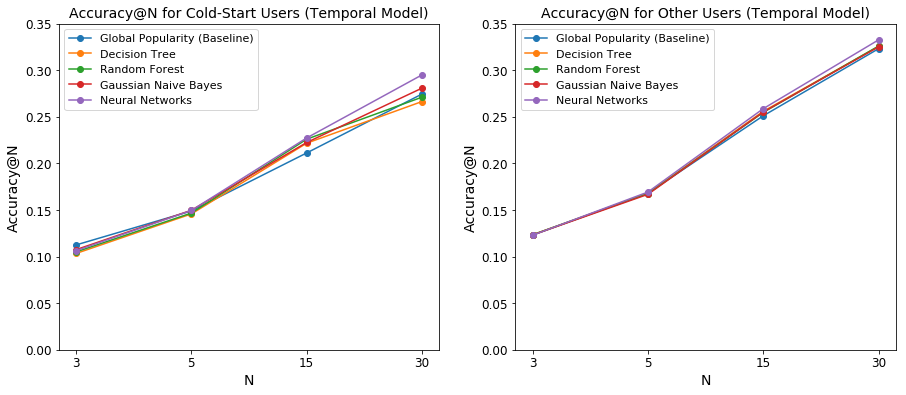

In [40]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

plt.figure(figsize = (15, 6))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = TemporalTree1.classes_[Proba_TemporalTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = TemporalRF1.classes_[Proba_TemporalRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = TemporalGNB1.classes_[Proba_TemporalGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = TemporalNN1_Classes[Proba_TemporalNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.36, 0.05), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Temporal Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = TemporalTree1.classes_[Proba_TemporalTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = TemporalRF1.classes_[Proba_TemporalRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = TemporalGNB1.classes_[Proba_TemporalGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = TemporalNN1_Classes[Proba_TemporalNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.36, 0.05), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Temporal Model)', fontsize = 14)
                         
plt.show()
plt.close()

In [41]:
# Popular Jap Restaurants
popJapRest = trainData \
    .groupby('venueId')['localTime', 'latitude', 'longitude'] \
    .agg({'localTime': 'count', 'latitude': 'mean', 'longitude': 'mean'}) \
    .sort_values(by = 'localTime', ascending = False)
popJapRest = popJapRest.loc[popJapRest.localTime > 250, :]

In [42]:
popJapRest.loc[:, ['longitude', 'latitude']].to_csv('popJapRestaurants_Coordinates.csv', index = False, encoding = 'utf-8')

In [43]:
fig = plt.figure(figsize=(20,10))

plt.title('Map of Tokyo with Popular Japanese Restaurants')

# Create subplot
ax = fig.add_subplot(111)

map1 = Basemap(llcrnrlon = 129.5, llcrnrlat = 30.5, 
               urcrnrlon = 142,urcrnrlat = 42.5, resolution = 'l')

map1.drawcountries()

map1.drawmapboundary(fill_color='#7777ff')
map1.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map1.drawcoastlines()

restLats, restLongs = map1(popJapRest['latitude'].values, popJapRest['longitude'].values)

# adjust size and location of subplot
axins = zoomed_inset_axes(ax, 10, loc = 2)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon = np.min(popJapRest['longitude']) - 0.1, 
               llcrnrlat = np.min(popJapRest['latitude']) - 0.1, 
               urcrnrlon = np.max(popJapRest['longitude']) + 0.1, 
               urcrnrlat = np.max(popJapRest['latitude']) + 0.1, resolution = 'h')

map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(restLongs, restLats, color = 'r')

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")

#plt.show()
plt.savefig('tokyo.png')
plt.close()

### Simulation 2: Spatio-Temporal Models

In [44]:
predictorVars_SpatioLastLoc = ['localDayofWeek', 'localHour', 'usrLastX', 'usrLastY', 'usrLastZ', 'usrLastTimeDiff']

In [45]:
# Decision Tree
SpatioLastLoc_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), predictorVars_SpatioLastLoc].as_matrix()
Venue_Ytest_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

SpatioLastLoc_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), predictorVars_SpatioLastLoc].as_matrix()
Venue_Ytest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

starttime = datetime.now()

SpatioLastLocTree1 = predictMultiClassProba(trainData, 
                                            GridSearchCV(tree.DecisionTreeClassifier(), 
                                                         param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                         cv = TimeSeriesSplit(n_splits = 10)), 
                                            targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Decision Tree: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocTree1_Cold = SpatioLastLocTree1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocTree1_NonCold = SpatioLastLocTree1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Decision Tree: ", datetime.now() - starttime)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Total time to train Decision Tree:  0:01:00.447368
Total time to predict using Decision Tree:  0:00:00.345246


In [46]:
# Random Forest
starttime = datetime.now()

SpatioLastLocRF1 = predictMultiClassProba(trainData, 
                                          GridSearchCV(ensemble.RandomForestClassifier(n_estimators = 10), 
                                                       param_grid = {"min_samples_leaf": [50, 200, 500]}, 
                                                       cv = TimeSeriesSplit(n_splits = 10)), 
                                          targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Random Forest: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocRF1_Cold = SpatioLastLocRF1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocRF1_NonCold = SpatioLastLocRF1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Random Forest1: ", datetime.now() - starttime)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Total time to train Random Forest:  0:05:01.982984
Total time to predict using Random Forest1:  0:00:04.712412


In [47]:
# Gaussian Naive Bayes
starttime = datetime.now()

SpatioLastLocGNB1 = predictMultiClassProba(trainData, 
                                           naive_bayes.GaussianNB(), 
                                           targetVar_Venue, predictorVars_SpatioLastLoc)

print("Total time to train Gaussian Naive Bayes: ", datetime.now() - starttime)

starttime = datetime.now()

Proba_SpatioLastLocGNB1_Cold = SpatioLastLocGNB1.predict_proba(SpatioLastLoc_Xtest_Cold)
Proba_SpatioLastLocGNB1_NonCold = SpatioLastLocGNB1.predict_proba(SpatioLastLoc_Xtest_NonCold)

print("Total time to predict using Gaussian Naive Bayes: ", datetime.now() - starttime)

Total time to train Gaussian Naive Bayes:  0:00:03.412968
Total time to predict using Gaussian Naive Bayes:  0:00:06.045742


In [48]:
SpatioLastLocNN1_Classes, SpatioLastLocNN1, SpatioLastLocNN1_Scaler = predictNNMultiClassProba(trainData, targetVar_Venue, 
                                                                                               predictorVars_SpatioLastLoc, 
                                                                                               epochsize = 75, batchsize = 10000, 
                                                                                               lrate = 0.005, scale = True)

Proba_SpatioLastLocNN1_Cold = SpatioLastLocNN1.predict_proba(SpatioLastLocNN1_Scaler.transform(SpatioLastLoc_Xtest_Cold.astype(float)))
Proba_SpatioLastLocNN1_NonCold = SpatioLastLocNN1.predict_proba(SpatioLastLocNN1_Scaler.transform(SpatioLastLoc_Xtest_NonCold.astype(float)))


Epoch 1/75
2s - loss: 6.2358 - acc: 0.0363
Epoch 2/75
2s - loss: 5.9384 - acc: 0.0537
Epoch 3/75
2s - loss: 5.6925 - acc: 0.0622
Epoch 4/75
2s - loss: 5.5248 - acc: 0.0688
Epoch 5/75
2s - loss: 5.4087 - acc: 0.0743
Epoch 6/75
2s - loss: 5.3418 - acc: 0.0772
Epoch 7/75
2s - loss: 5.2919 - acc: 0.0785
Epoch 8/75
2s - loss: 5.2524 - acc: 0.0803
Epoch 9/75
2s - loss: 5.2211 - acc: 0.0825
Epoch 10/75
2s - loss: 5.1901 - acc: 0.0838
Epoch 11/75
2s - loss: 5.1650 - acc: 0.0849
Epoch 12/75
2s - loss: 5.1375 - acc: 0.0863
Epoch 13/75
2s - loss: 5.1181 - acc: 0.0880
Epoch 14/75
2s - loss: 5.1033 - acc: 0.0883
Epoch 15/75
2s - loss: 5.0874 - acc: 0.0905
Epoch 16/75
2s - loss: 5.0688 - acc: 0.0919
Epoch 17/75
2s - loss: 5.0516 - acc: 0.0925
Epoch 18/75
2s - loss: 5.0399 - acc: 0.0934
Epoch 19/75
2s - loss: 5.0249 - acc: 0.0944
Epoch 20/75
2s - loss: 5.0111 - acc: 0.0947
Epoch 21/75
2s - loss: 5.0001 - acc: 0.0954
Epoch 22/75
2s - loss: 4.9849 - acc: 0.0961
Epoch 23/75
2s - loss: 4.9719 - acc: 0.09

In [49]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.112544400823
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.123116188624
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.263600673023
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.374885215794
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.275752477099
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.392994112245
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.135165451486
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.160927456382
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.201159095158
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.245165559337

N = 5 

Venue Accuracy@5 for Cold-Star

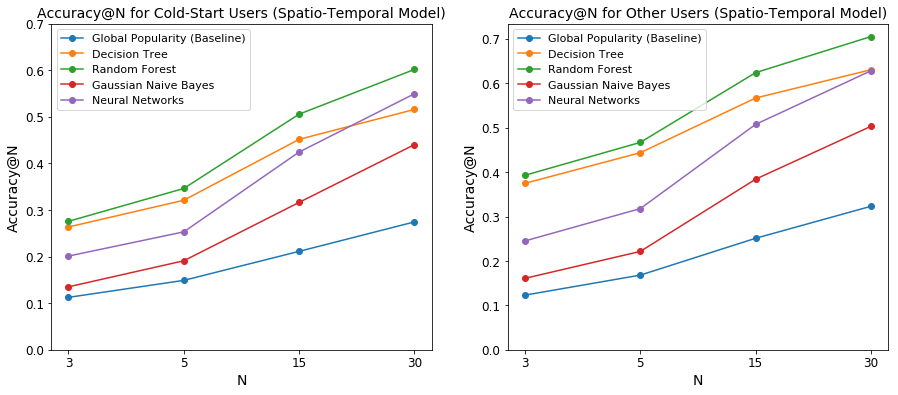

In [50]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

plt.figure(figsize = (15, 6))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.71, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Spatio-Temporal Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.71, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Spatio-Temporal Model)', fontsize = 14)
                         
plt.show()
plt.close()

### Simulation 3: User Preference Factors

#### Use User-VenuePreference Matrix to Normalise

In [51]:
# Construct User-Ven Preference Matrix from Training Set
trainUID = set(trainData.userId)
trainVen = set(trainData.venueId)

usrVenMatrix = []

for uid in trainUID:
    
    currDF = trainData.loc[trainData.userId == uid, ['userId', 'venueId']]
    venMatrixRow = []
    
    for ven in trainVen:
        venMatrixRow.append(np.sum(currDF['venueId'] == ven) + 1) # Laplacian Smoothing: +1
        
    usrVenMatrix.append(venMatrixRow)

usrVenMatrix = np.array(usrVenMatrix)
usrVenMatrix = usrVenMatrix / np.sum(usrVenMatrix, axis = 1)[:, np.newaxis] # Divide by rowsum to get probability
usrVenMatrix = pd.DataFrame(usrVenMatrix, index = trainUID, columns = trainVen)

In [52]:
# Normalise probabilities for Cold-Start User estimations
UID_Xtest_Cold = testData.loc[testData.userId.isin(coldStartUsers), 'userId'].as_matrix()

# Fill NA with 1 for users not found in usrCatMatrix (assume no specific preference in any category)
Proba_SpatioLastLocTree1_Cold_Norm = Proba_SpatioLastLocTree1_Cold * \
                                        usrVenMatrix.loc[UID_Xtest_Cold, SpatioLastLocTree1.classes_].fillna(1).as_matrix()

Proba_SpatioLastLocRF1_Cold_Norm = Proba_SpatioLastLocRF1_Cold * \
                                        usrVenMatrix.loc[UID_Xtest_Cold, SpatioLastLocRF1.classes_].fillna(1).as_matrix()

Proba_SpatioLastLocGNB1_Cold_Norm = Proba_SpatioLastLocGNB1_Cold * \
                                        usrVenMatrix.loc[UID_Xtest_Cold, SpatioLastLocGNB1.classes_].fillna(1).as_matrix()

Proba_SpatioLastLocNN1_Cold_Norm = Proba_SpatioLastLocNN1_Cold * \
                                        usrVenMatrix.loc[UID_Xtest_Cold, SpatioLastLocNN1_Classes].fillna(1).as_matrix()

# Normalise probabilities for Non-Cold User estimations
UID_Xtest_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), 'userId'].as_matrix()

# Fill NA with 1 for users not found in usrCatMatrix (assume no specific preference in any category)
Proba_SpatioLastLocTree1_NonCold_Norm = Proba_SpatioLastLocTree1_NonCold * \
                                        usrVenMatrix.loc[UID_Xtest_NonCold, SpatioLastLocTree1.classes_].fillna(1).as_matrix()

Proba_SpatioLastLocRF1_NonCold_Norm = Proba_SpatioLastLocRF1_NonCold * \
                                        usrVenMatrix.loc[UID_Xtest_NonCold, SpatioLastLocRF1.classes_].fillna(1).as_matrix()
    
Proba_SpatioLastLocGNB1_NonCold_Norm = Proba_SpatioLastLocGNB1_NonCold * \
                                        usrVenMatrix.loc[UID_Xtest_NonCold, SpatioLastLocGNB1.classes_].fillna(1).as_matrix()
    
Proba_SpatioLastLocNN1_NonCold_Norm = Proba_SpatioLastLocNN1_NonCold * \
                                        usrVenMatrix.loc[UID_Xtest_NonCold, SpatioLastLocNN1_Classes].fillna(1).as_matrix()


In [53]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

for N in [3, 5, 15, 30]:
    
    print("\nN =", N, "\n")

    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Global Popularity Method: ", 
          calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))

    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Decision Tree Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))

    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Random Forest Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))

    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Gaussian NB Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))

    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]

    print("Venue Accuracy@" + str(N) + " for Cold-Start Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    print("Venue Accuracy@" + str(N) + " for Non-Cold Users using Neural Network Estimated Probabilities: ", 
          calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))


N = 3 

Venue Accuracy@3 for Cold-Start Users using Global Popularity Method:  0.112544400823
Venue Accuracy@3 for Non-Cold Users using Global Popularity Method:  0.123116188624
Venue Accuracy@3 for Cold-Start Users using Decision Tree Estimated Probabilities:  0.285847822023
Venue Accuracy@3 for Non-Cold Users using Decision Tree Estimated Probabilities:  0.487589801761
Venue Accuracy@3 for Cold-Start Users using Random Forest Estimated Probabilities:  0.300616937745
Venue Accuracy@3 for Non-Cold Users using Random Forest Estimated Probabilities:  0.515313563442
Venue Accuracy@3 for Cold-Start Users using Gaussian NB Estimated Probabilities:  0.16844269957
Venue Accuracy@3 for Non-Cold Users using Gaussian NB Estimated Probabilities:  0.391157564954
Venue Accuracy@3 for Cold-Start Users using Neural Network Estimated Probabilities:  0.234623294074
Venue Accuracy@3 for Non-Cold Users using Neural Network Estimated Probabilities:  0.457705396208

N = 5 

Venue Accuracy@5 for Cold-Start

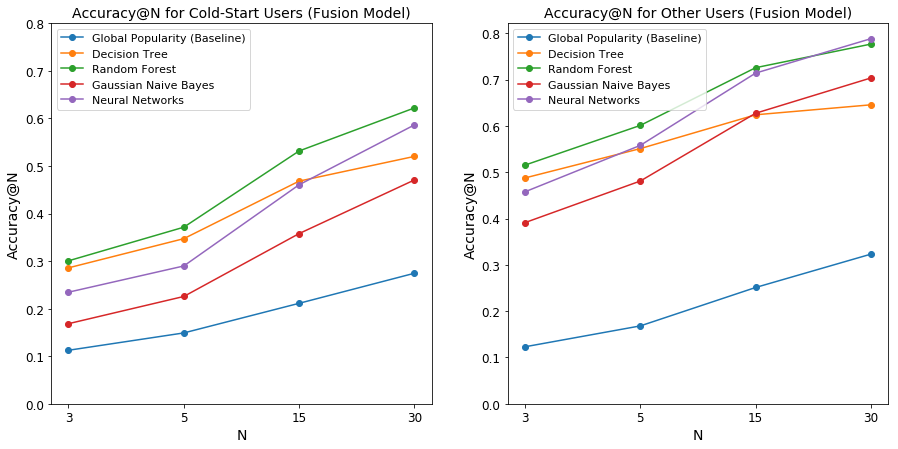

In [56]:
test_TrueVenues_Cold = testData.loc[testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()
test_TrueVenues_NonCold = testData.loc[~testData.userId.isin(coldStartUsers), targetVar_Venue].as_matrix()

plt.figure(figsize = (15, 7))

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

NList = [3, 5, 15, 30]
for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_Cold, np.repeat(global_TopN_Venues, len(test_TrueVenues_Cold), axis = 0)))
    
    Tree_TopN_Venues_Cold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_Cold, Tree_TopN_Venues_Cold))
    
    RF_TopN_Venues_Cold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_Cold, RF_TopN_Venues_Cold))
    
    GNB_TopN_Venues_Cold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_Cold, GNB_TopN_Venues_Cold))
    
    NN_TopN_Venues_Cold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_Cold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_Cold, NN_TopN_Venues_Cold))
    
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.81, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Cold-Start Users (Fusion Model)', fontsize = 14)

globalPopAccN = []
treeAccN = []
rfAccN = []
gnbAccN = []
nnAccN = []

for N in NList:
    
    global_TopN_Venues = np.array([trainData.groupby(targetVar_Venue)['localTime'].count().sort_values(ascending = False).index[:N]])    
    globalPopAccN.append(calcAccN(test_TrueVenues_NonCold, np.repeat(global_TopN_Venues, len(test_TrueVenues_NonCold), axis = 0)))
    
    Tree_TopN_Venues_NonCold = SpatioLastLocTree1.classes_[Proba_SpatioLastLocTree1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    treeAccN.append(calcAccN(test_TrueVenues_NonCold, Tree_TopN_Venues_NonCold))
    
    RF_TopN_Venues_NonCold = SpatioLastLocRF1.classes_[Proba_SpatioLastLocRF1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    rfAccN.append(calcAccN(test_TrueVenues_NonCold, RF_TopN_Venues_NonCold))
    
    GNB_TopN_Venues_NonCold = SpatioLastLocGNB1.classes_[Proba_SpatioLastLocGNB1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    gnbAccN.append(calcAccN(test_TrueVenues_NonCold, GNB_TopN_Venues_NonCold))
    
    NN_TopN_Venues_NonCold = SpatioLastLocNN1_Classes[Proba_SpatioLastLocNN1_NonCold_Norm.argsort(axis = 1)[:, -N:][:, ::-1]]
    nnAccN.append(calcAccN(test_TrueVenues_NonCold, NN_TopN_Venues_NonCold))

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(NList)), globalPopAccN, marker = 'o', label = "Global Popularity (Baseline)")
plt.plot(np.arange(len(NList)), treeAccN, marker = 'o', label = "Decision Tree")
plt.plot(np.arange(len(NList)), rfAccN, marker = 'o', label = "Random Forest")
plt.plot(np.arange(len(NList)), gnbAccN, marker = 'o', label = "Gaussian Naive Bayes")
plt.plot(np.arange(len(NList)), nnAccN, marker = 'o', label = "Neural Networks")

plt.xticks(np.arange(len(NList)), NList, rotation = 0, fontsize = 12)
plt.yticks(np.arange(0, 0.81, 0.1), fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel('Accuracy@N', fontsize = 14)
plt.xlabel('N', fontsize = 14)
plt.title('Accuracy@N for Other Users (Fusion Model)', fontsize = 14)
                         
plt.show()
plt.close()